In [1]:
# numpy and pandas for data manipulation
import pandas as pd 
pd.options.mode.chained_assignment = None # no warnings
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from wordcloud import WordCloud


# import tensorflow, , keras
import sys
sys.path.append('./')
from text_processing import text_processing
from classifiers import batch_classify
#from train import train
import tensorflow_hub as hub

Load Data
Load data using read_csv()

In [2]:
# reading in the CSV files using the pandas read_csv function. we have also dropped the id column from the train set as we won’t need this for training the model.
train = pd.read_csv('./Data/train.csv').drop('id', axis=1)
test = pd.read_csv('./Data/test.csv')
ID = test['id']
test = test.drop('id', axis=1)
test['target']=''



Data Preprocessing
Using the following text preprocessing methods:
[1] Format text: correct spelling, remove emojis, and remove stop_words
[2] Format keyword: fill missing keywords for certain tweets following specific scenarios
[3] Format location: fill missing locations for certain tweets following specific scenarios

** For deatils per each scenario, please follow the text_processing documentation

Scikit-pipeline
Next, we will create a scikit-pipeline with following methods:
[1] CountVectorizer() - split data into tokens, or individual words, count the frequency in which each word appears in the text, and then represent theses counts as a sparse matrix
[2] TfidfTransformer() - apply a weightning to the word counts produced by CountVectorizer(), this weightning is to scale down impact of very frequently occuring words in the text
[3] SGDClassifier() - generally regarded as one of the best text classification algorithms

In [3]:
train_clean = text_processing(train)
test_clean = text_processing(test)
train_clean.to_csv('./Data/train_clean.csv', index=False)
test_clean.to_csv('./Data/test_clean.csv', index=False)


C:\Users\lenovo\anaconda3\envs\ds\lib\site-packages\geopy\point.py:455: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(latitude, longitude, altitude)
C:\Users\lenovo\anaconda3\envs\ds\lib\site-packages\geopy\point.py:455: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(latitude, longitude, altitude)
C:\Users\lenovo\anaconda3\envs\ds\lib\site-packages\geopy\point.py:455: UserWarning: Latitude normalization has been prohibi

In [4]:
train_clean.to_csv('./Data/train_clean.csv', index=False)
test_clean.to_csv('./Data/test_clean.csv', index=False)

In [5]:
train_clean = pd.read_csv('./Data/train_clean.csv')
test_clean = pd.read_csv('./Data/test_clean.csv')

In [6]:
# searching for duplicated tweets with different target and removing them
df_mislabeled = train_clean.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
train_clean = train_clean[~train_clean['text'].isin(df_mislabeled.index.tolist())]
# removing tweets that have less than 3 words
train_clean = train_clean[train_clean['text'].apply(lambda x: len(x) >= 3)]

GRAPHS

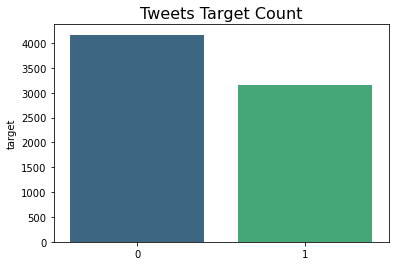

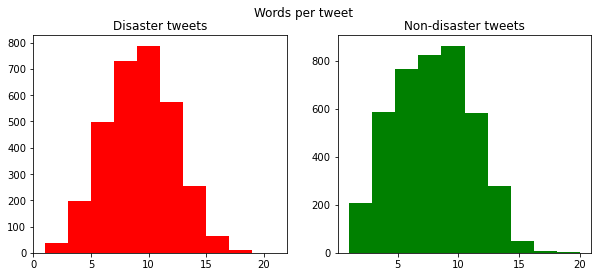

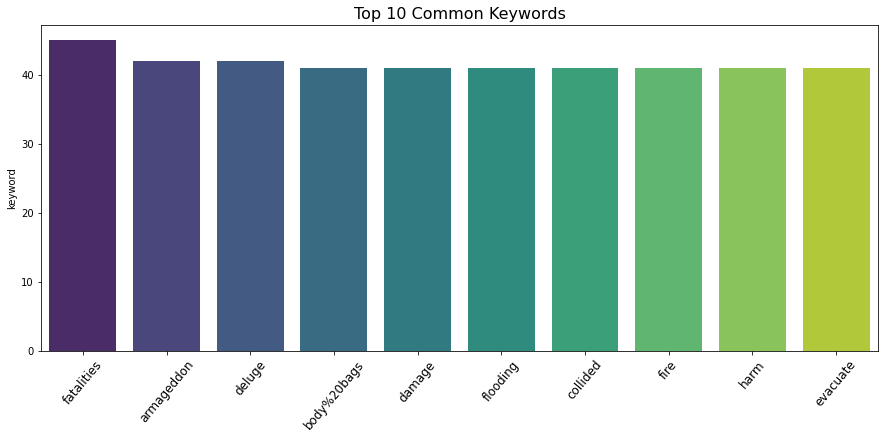

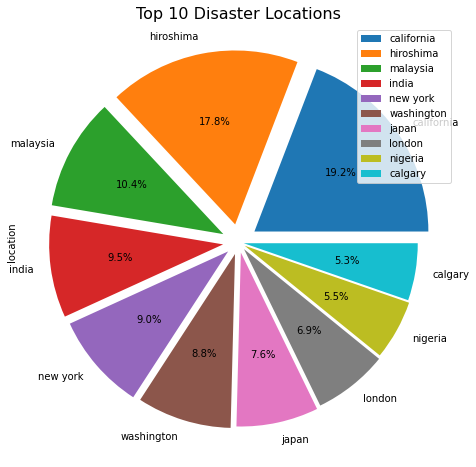

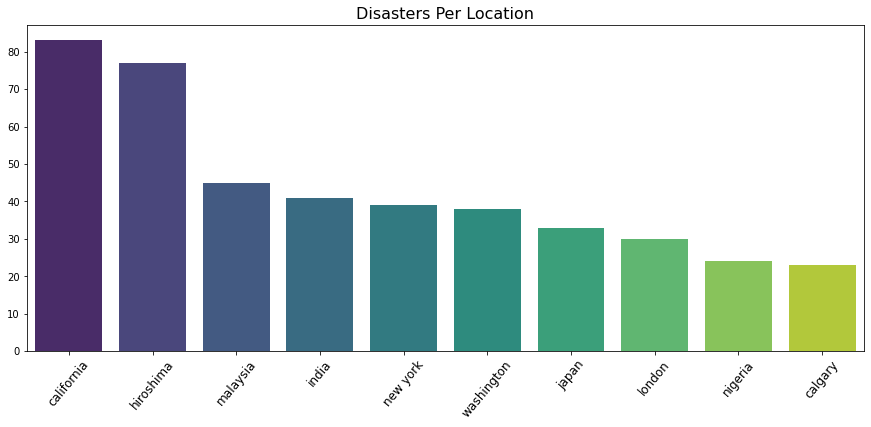

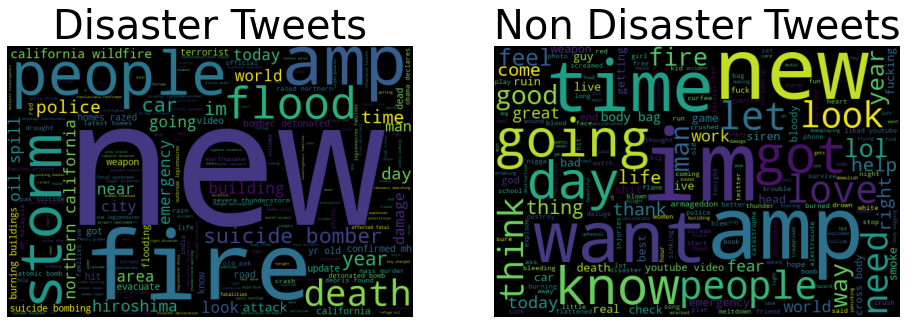

In [7]:
# tweets target count
count_target = train_clean['target'].value_counts().to_frame()
sns.barplot(data=count_target, x=count_target.index, y="target", palette="viridis")
plt.title("Tweets Target Count", size=16)
plt.show()

# PLOTTING WORD-COUNT
train_clean['word_count'] = train_clean['text'].apply(lambda x: len(str(x).split()))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=train_clean[train_clean['target']==1]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Disaster tweets')
train_words=train_clean[train_clean['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

# top 10 common keywords
common_keywords = train_clean["keyword"].value_counts()[:10].to_frame()
fig = plt.figure(figsize=(15,6))
sns.barplot(data=common_keywords, x=common_keywords.index, y="keyword", palette="viridis")
plt.title("Top 10 Common Keywords", size=16)
plt.xticks(rotation=50, size=12)
plt.show()

# top 10 disaster locations
top_10_disaster_locations = train_clean['location'][train_clean['target']==1].value_counts().to_frame()[:10]
top_10_disaster_locations.plot(kind='pie', y='location', figsize=(8, 8), explode=(0.11,0.105,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03), autopct='%1.1f%%')
plt.title('Top 10 Disaster Locations', size=16) 
plt.show()

# disaster per location
a = plt.figure(figsize=(15,6))
a = sns.barplot(data=top_10_disaster_locations, x=top_10_disaster_locations.index, y="location", palette="viridis")
a.set(ylabel=None)
plt.title("Disasters Per Location", size=16)
plt.xticks(rotation=50, size=12)
plt.show()

# word cloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
## disaster tweets
disaster_tweets = train_clean[train_clean['target']==1]['text']
wordcloud1 = WordCloud(background_color='black', width=600, height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40)
## non disaster tweets
non_disaster_tweets = train_clean[train_clean['target']==0]['text']
wordcloud2 = WordCloud(background_color='black', width=600, height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40)
plt.show()

In [8]:
X = train_clean.drop('target', axis = 1)
y = train_clean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4, shuffle = True)

In [9]:

# split the train data into a training and test set

X_train, X_test, y_train, y_test = train_test_split(train_clean['text'], train_clean['target'], test_size=0.20, random_state=0)

Try Different Classifiers

In [68]:
tweets_pipeline = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer())])

X_train_tranformed = tweets_pipeline.fit_transform(X_train)
X_test_tranformed = tweets_pipeline.transform(X_test)

In [ ]:

df_results = batch_classify(X_train_tranformed, y_train,X_test_tranformed, y_test)
print(df_results.sort_values(by='F1_score', ascending=False))

In [10]:
# ML pipeline
pipeline_LR = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('nb', LogisticRegression(C= 1, max_iter= 100, penalty= "l2", solver= "newton-cg"))
])

model = pipeline_LR.fit(X_train, y_train)
y_predict = model.predict(X_test)
target_names = ['Non-disaster Tweet', 'Disaster Tweet']
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.78      0.92      0.85       826
           1       0.86      0.67      0.76       639

    accuracy                           0.81      1465
   macro avg       0.82      0.79      0.80      1465
weighted avg       0.82      0.81      0.81      1465



Submission

In [13]:
submission_test_clean = test_clean.copy()['text'].fillna(' ')
submission_test_pred = pipeline_LR.predict(submission_test_clean)
submission_df_1 = pd.DataFrame({"id": ID,
                               "target": submission_test_pred})
submission_df_1.to_csv('submission_1.csv', index=False)

In [63]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})